# 실습: Darknet을 이용하여 커스텀 YOLOv3를 빌드하기

This tutorial is a copy of the one made by 'The AI Guy'.
The link to the original tutorial and the author is : [The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q)

폴더등과 관련된 몇 가지 오류를 수정하고 한글화함

# 1. Darknet를 clone하기

다음 셀들은
<ol>
<li> AlexeyAB repository에서 darknet을 clone하고 </li>
<li> darknet에서 OPENCV and GPU의 사용을 enable하기 위해 make파일을 수정하고 </li>
<li> darknet을 빌드함 </li>
</ol>

In [ ]:
# darknet repository에서 clone하기
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15851, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15851 (delta 5), reused 13 (delta 4), pack-reused 15833
Receiving objects: 100% (15851/15851), 14.42 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (10671/10671), done.


In [ ]:

#GPU와 OPENCV의 사용이 가능하도록  makefile을 수정하기
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
# CUDA버전 확인하기
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# make를 이용하여 darknet를 build
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘buff’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warn

# 2. Helper 함수 정의
업로드, 다운로드, imShow등과 관련된 함수 정의

In [ ]:
# helper함수들
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)  #경로로부터 이미지를 불러읽어들여서
  height, width = image.shape[:2]   #현재 영상의 height와 width를 읽어서
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC) #영상을 3배로 키운다(크게 보여주기 위해서)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  #opencv로 읽어들인 영상은 BGR포맷을 갖기 때문에 RGB포맷으로 변환해야 함
  plt.show()

# google colab으로 파일을 업로드할 때 사용하는 함수를 정의
def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# google colab에서 파일을 다운로드할 때 사용하는 함수를 정의
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# 다음은 /content/gdrive/My\ Drive/ 의 경로를 /mydrive 로 접근할 수 있도록 링크를 만들어준다.
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'   yolov3  '제목없는 프레젠테이션.gslides'


# 3. 클라우드에서 커스텀 YOLOv3 Object Detector를 학습시키기

커스텀 YOLOv3 detector를 학습하려면 다음이 필요하다:

*   라벨을 가진 커스텀 데이터셋
*   커스텀 .cfg file
*   obj.data 와 obj.names 파일들
*   train.txt file (test.txt 는 있어도 되고 없어도 됨)


# Step 1: 커스텀 데이터셋 마련

커스텀 custom object detector를 만들려면 이미지와 라벨을 가진 데이터셋을 마련해야 한다.

다음의 2가지 방법을 이용할 수 있다.

### 방법 1: 구글의 Open Images Dataset을 이용하기

구글의 Open Images Dataset에서 데이터셋을 얻어서 OIDv4 toolkit 등으로 라벨을 생성하는 방법은 쉽고 빠르다. 구글의 Open Images Dataset은 600개가 넘는 클래스들에 대하여 라벨링이 된 이미지들을 가지고 있다.
 [여기서 데이터셋을 찾아보기](https://storage.googleapis.com/openimages/web/index.html)

다음 비디오에는 구글의 Open Images Dataset을 이용하여 자신만의 커스텀 데이터셋을 만드는 방법에 대해 설명하고 있다:

[Creating a Custom YOLOv3 Dataset (Video)](https://www.youtube.com/watch?v=_4A9inxGqRM)

다음 링크는 OIDv4 toolkit!에 대한 Gihub의 repository에 대한 링크임: [Github Repo](https://github.com/theAIGuysCode/OIDv4_ToolKit)

이 튜토리얼에서는 구글의 Open Images Dataset을 이용하여 safari animal object detector를 위한 이미지 데이터셋을 만들고자 한다.
OIDv4 toolkit안에서 다음의 코멘드를 실행한다.

```
python main.py downloader --classes Elephant Giraffe Hippopotamus Tiger Zebra --type_csv train --limit 300 --multiclasses 1
```

그러면 Elephant, Giraffe, Hippopotamus, Tiger, Zebra의 영상들이 하나의 폴더에 들어가게 된다. 각 클래스에 대해 300개의 이미지가 생겨서 전체적으로는 1500개의 영상이 하나의 폴더안에 생기게 된다.

OIDv4_ToolKit의 root folder폴더에서 classes.txt라는 파일을 열고 다음과 같이 각 라인에 클래스명을 하나씩 적어놓는다.
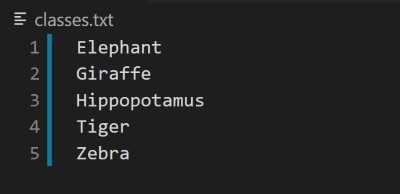

이제 다음의 명령문으로 이미지의 annotation을 변환시키면 됨:
```
python convert_annotations.py
```
위의 명령문은 모든 라벨을 YOLOv3에서 사용하는 포맷으로 변환시켜서 커스텀 object detector를 학습시킬 수 있는 형태가 되게 한다.

OIDv4 toolkit의 옛날 'Label' 폴더 제거하기:
다음 명령문을 실행하여 YOLOv3에서 사용하지 못하는 라벨을 제거한다: (경로명은 어떤 클래스를 다운로드를 받았는지에 따라 달라진다.
```
rm -r OID/Dataset/train/Elephant_Giraffe_Hippopotamus_Tiger_Zebra/Label/
```
위의 명령어가 먹히지 않으면 직접 'Label'이라는 폴더를 찾아서 제거해도 된다.

모든 이미지와 annotation을 포함하는 폴더의 내용은 다음과 같게 된다. 여기서 각 이미지 이름과 같은 텍스트 파일이 쌍으로 생김을 볼 수 있다.

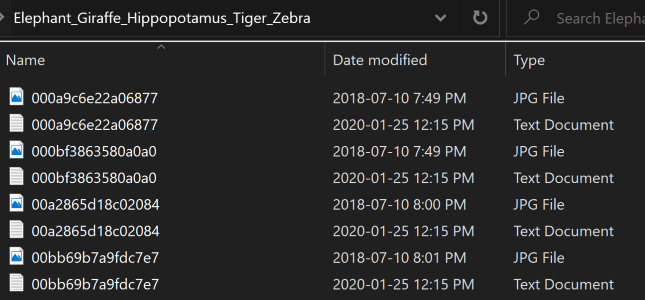

## 여기까지 하면 커스텀 YOLOv3 dataset의 생성이 완료된 것임.

### 방법 2: Annotation Tool을 사용하여 수동으로 annotation을 만들기

만약 구글의 Open Images Dataset에 적당한 이미지나 클래스를 찾을 수 없다면 수동으로 라벨을 그리는 방법이 있다. 이 방법은 상당히 노력이 필요한 방법이다.

밑의 유튜브는 annotation tool인 LabelImg를 사용하여 YOLOv3를 위한 커스텀 데이터셋을 만드는 방법을 설명하고 있다.

[Create Labels and Annotations for Custom YOLOv3 Dataset (Video)](https://www.youtube.com/watch?v=EGQyDla8JNU)

위의 튜터리얼 영상을 따라하면 마찬가지로 이미지와 텍스트파일이 존재하는 폴더가 생길 것이다.

## 여기까지 하면 커스텀 YOLOv3 dataset의 생성이 완료된 것임.

# Step 2: 커스텀 데이터셋을 클라우드에 올리기

데이터셋의 포맷을 학습하기에 적합하도록 변환한 후에는 데이터셋을 클라우드에 올려야 한다.

이미지와 텍스트 파일이 있는 폴더명을  '**obj**' 라고 한 다음에 'obj' 폴더를 zip파일로 압축하여 클라우드로 업로드하고 클라우드에서 zip파일을 압축풀기하면 된다.

In [ ]:
# 압축한 zip파일을 넣은 폴더
!ls /mydrive/yolov3

backup	classes.txt.txt  generate_train.py  obj.data  obj.names  obj.zip  pre.py  yolov3_custom.cfg


In [ ]:
cd darknet

/content/darknet


In [ ]:
# obj.zip파일을 클라우드의 root directory로 copy하기
!cp /mydrive/yolov3/obj.zip ../

In [ ]:
!ls

3rdparty	darknet			Dockerfile.cpu	       Makefile       scripts
backup		DarknetConfig.cmake.in	Dockerfile.gpu	       net_cam_v3.sh  src
build		darknet_images.py	image_yolov3.sh        net_cam_v4.sh  vcpkg.json
build.ps1	darknet.py		image_yolov4.sh        obj	      vcpkg.json.opencv23
cfg		darknet_video.py	include		       package.xml    video_yolov3.sh
cmake		data			json_mjpeg_streams.sh  README.md      video_yolov4.sh
CMakeLists.txt	docker-compose.yml	LICENSE		       results


In [ ]:
# 다음과 같이 zip파일을 압축풀기하면 파일안의 내용들이 /darknet/data/obj 안에 있게 된다
!unzip ../obj.zip -d data/obj/

Archive:  ../obj.zip
  inflating: data/obj/test/1.jpg     
  inflating: data/obj/test/1.txt     
  inflating: data/obj/test/101.jpg   
  inflating: data/obj/test/101.txt   
  inflating: data/obj/test/103.jpg   
  inflating: data/obj/test/103.txt   
  inflating: data/obj/test/105.jpg   
  inflating: data/obj/test/105.txt   
  inflating: data/obj/test/107.jpg   
  inflating: data/obj/test/107.txt   
  inflating: data/obj/test/109.jpg   
  inflating: data/obj/test/109.txt   
  inflating: data/obj/test/11.jpg    
  inflating: data/obj/test/11.txt    
  inflating: data/obj/test/111.jpg   
  inflating: data/obj/test/111.txt   
  inflating: data/obj/test/113.jpg   
  inflating: data/obj/test/113.txt   
  inflating: data/obj/test/115.jpg   
  inflating: data/obj/test/115.txt   
  inflating: data/obj/test/117.jpg   
  inflating: data/obj/test/117.txt   
  inflating: data/obj/test/119.jpg   
  inflating: data/obj/test/119.txt   
  inflating: data/obj/test/121.jpg   
  inflating: data/obj/test/12

# Step 3: 학습할 수 있도록 파일들의 설정을 바꾸기

.cfg 파일, obj.data, obj.names, train.txt 파일들에 대해 설정을 바꾸기


다음 유튜브에는 파일들의 설정을 바꾸는 방법이 잘 설명되어 있다 [Configuring YOLOv3 Files for Training](https://www.youtube.com/watch?v=zJDUhGL26iU&t=300s)

## i) Cfg 파일
먼저 yolov3.cfg 를 copy하고 편집하기

In [ ]:
# cfg파일을 구글 드라이브로 복사하고 이름을 바꾸기
!cp cfg/yolov3.cfg /mydrive/yolov3/yolov3_custom.cfg

In [ ]:
# PC로 다운로드하려면 다음과 같이 하면 된다. 다운로드후에는 파일 이름을 yolov3_custom.cfg로 바꾸면 된다.
download('cfg/yolov3.cfg')

이제 편집기를 이용하여 .cfg파일을 편집하면 된다.

yolov3_custom.cfg파일 구글 드라이브에 있다면 파일을 더블클릭한 후에 **Open with** 드롭다운에서  **Text Editor**를 선택하면 된다.
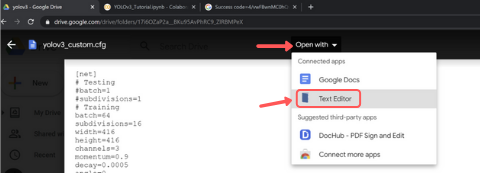

추천:  **batch = 64** 와 **subdivisions = 16** 로 놓는 것을 추천함. 문제가 생기면 subdivisions 은 32까지 올릴 수 있다.

몇개의 class에 대하여 학습하는지에 따라 변경사항이 달라짐.

여기서는  **max_batches = 10000**, **steps = 8000, 9000**, I  **classes = 5** 로 놓았고, 각 YOLO 레이어전의 3개의 컨볼루셔널 레이어에서는 **filters = 30** 로 놓았다. (주의 : 이런 classes가 cfg파일안에 3개가 있다)

**옵션:** 학습을 빠르게 하려면 cfg파일안의 yolo레이어에서 random = 1 에서 **random = 0** 으로 바꿀 수 있음. 대신 정확도는 약간 떨어지게 됨. 이렇게 함으로써 메모리 부족현상도 어느 정도 완화될 수 있다.

save to drive버튼을 눌러서 save함.

In [ ]:
# 커스텀 .cfg 파일을 다시 클라우드로 올림
!cp /mydrive/yolov3/yolov3_custom.cfg ./cfg
!cp /mydrive/yolov3/train.txt ./data
!cp /mydrive/yolov3/test.txt ./data
# 다음과 같이 하면 PC에서 커스텀 .cfg 파일을 클라우드로 올릴 수 있음.
#%cd cfg
#upload()
#%cd ..

## ii) obj.names 와 obj.data
**obj.names** 라는 파일명을 만들고 classes.txt에 넣었던 것과 같은 내용을 입력함.

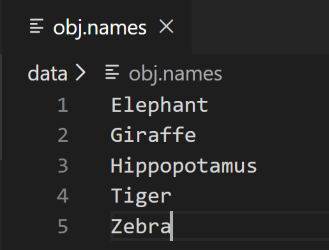

 **obj.data** 파일을 만들고 밑에와 같이 내용을 채움. 클래스의 갯수에 맞게 적고 backup 폴더의 위치를 지정하면 됨.

backup 폴더는 학습이 진행될 때 weights값들이 저장이 되는 위치임. 먼저 구글 드라이브에 backup폴더를 만든 후에 이 폴더로 위치를 지정하면 됨.

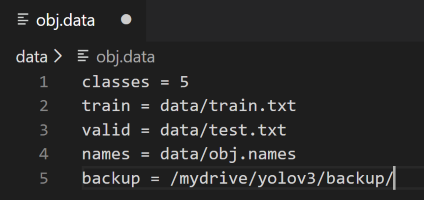



In [ ]:
# obj.names 와 obj.data 파일들을 구글 드라이브에서 클라우드로 올리기
!cp /mydrive/yolov3/obj.names ./data
!cp /mydrive/yolov3/obj.data  ./data

# obj.names 와 obj.data 파일들을 PC에서 클라우드로 올리기
#%cd data
#upload()
#%cd ..

In [ ]:
ls

3rdparty/       darknet53.conv.74       Dockerfile.gpu          net_cam_v4.sh*  vcpkg.json
backup/         DarknetConfig.cmake.in  image_yolov3.sh*        obj/            vcpkg.json.opencv23
build/          darknet_images.py       image_yolov4.sh*        package.xml     video_yolov3.sh*
build.ps1*      darknet.py              include/                README.md       video_yolov4.sh*
cfg/            darknet_video.py        json_mjpeg_streams.sh*  results/
cmake/          data/                   LICENSE                 scripts/
CMakeLists.txt  docker-compose.yml      Makefile                src/
darknet*        Dockerfile.cpu          net_cam_v3.sh*          test.txt


In [ ]:
cd darknet

/content/darknet


In [ ]:
!ls data

data


## iii) train.txt 만들기
마지막으로 만들어야 하는 파일은 train.txt파일로, 이 파일은 학습에 사용하는 이미지들에 대한 상대경로를 가지고 있는 파일이다.

train.txt 파일을 생성해주는 python script를 여기서 얻을 수 있다:[Github Repo](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)

이 파일을 PC나 구글드라이브에 다운로드한 후에 클라우드로 올리면 된다.

In [ ]:
# 구글드라이브의 generate_train.py 스크립트를 클라우드로 올리기
!cp /mydrive/yolov3/pre.py ./

# PC에서 generate_train.py 스크립트를 클라우드로 올리기
#upload()


다음과 같이 python 스크립트를 실행하면 train.txt파일을 생성해준다.

In [ ]:
!python pre.py

In [ ]:
# darknet/data폴더내에 train.txt이 존재함을 확인해보기
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


 **train.txt** 을 더블클릭하여 에디터로 내부를 확인해보면 다음과 같이 보여질 것이다.

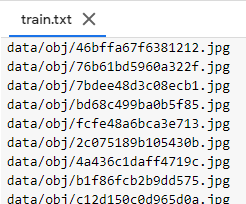

라인마다 학습 이미지 경로가 존재함을 확인할 수 있다.

# Step 4: 사전학습된 weights 들을 다운로드하기

이 step은 YOLOv3 네트워크의 컨볼루션 레이어에 대한 weights들을 다운로드하는 step이다. 사전학습된 weights 들을 이용하면 학습시간을 줄일 수 있고, 정확도도 높일 수 있다.

In [ ]:
# 사전학습된 convolutional layer weights를 다운로드하
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2024-05-28 14:14:33--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2024-05-28 14:14:33--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  52.0MB/s    in 3.0s    

2024-05-28 14:14:36 (52.0 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



# Step 5: 커스텀 Object Detector를 학습시키기

다음의 명령문으로 커스텀 Object Detector를 학습시킬 수 있다. 여기서 -dont_show 플래그는 chart를 보이지 않게 하는 플래그이다.
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```
**TIP:** 이 학습은 상당히 오래 걸리는데 구글 colab은 학습하다가 반응이 없으면 중간에 멈춘다. 이것을 방지 하기 위해 CTRL + SHIFT + i를 누른 후에 브라우저에 나타나는 console window에 다음의 코드를 복사하고 엔터키를 누른다.

```
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

위의 코드는 1분마다 스크린을 자동으로 클릭하여 colab이 멈추는 것을 방지하게 해준다.

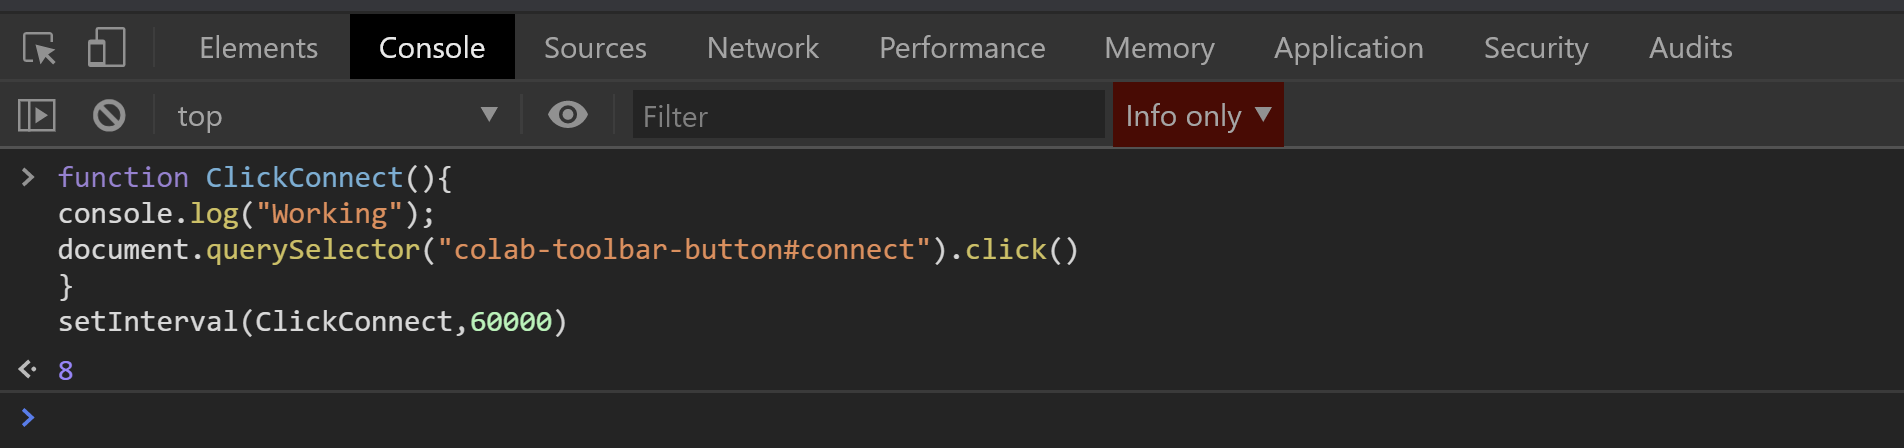

In [ ]:
!ls

3rdparty	darknet			docker-compose.yml     LICENSE	      results
backup		darknet53.conv.74	Dockerfile.cpu	       Makefile       scripts
build		DarknetConfig.cmake.in	Dockerfile.gpu	       net_cam_v3.sh  src
build.ps1	darknet_images.py	image_yolov3.sh        net_cam_v4.sh  vcpkg.json
cfg		darknet.py		image_yolov4.sh        obj	      vcpkg.json.opencv23
cmake		darknet_video.py	include		       package.xml    video_yolov3.sh
CMakeLists.txt	data			json_mjpeg_streams.sh  README.md      video_yolov4.sh


In [ ]:
cd darknet

/content/darknet


In [ ]:
!ls ../gdrive/MyDrive/yolov3/backup

yolov3_custom_last.weight


In [ ]:
!ls ../

darknet  gdrive  obj.zip  sample_data


In [ ]:
!ls

3rdparty	darknet53.conv.74	Dockerfile.cpu	       net_cam_v3.sh  test.txt
backup		darknet53.conv.74.1	Dockerfile.gpu	       net_cam_v4.sh  vcpkg.json
build		DarknetConfig.cmake.in	image_yolov3.sh        obj	      vcpkg.json.opencv23
build.ps1	darknet_images.py	image_yolov4.sh        package.xml    video_yolov3.sh
cfg		darknet.py		include		       README.md      video_yolov4.sh
cmake		darknet_video.py	json_mjpeg_streams.sh  results
CMakeLists.txt	data			LICENSE		       scripts
darknet		docker-compose.yml	Makefile	       src


In [ ]:
!ls ../gdrive/MyDrive/image

1.jpg  301.jpg


In [ ]:
# 커스텀 detector를 학습시키기. 기존에 학습하다 말았으면 backup에 있는 weight를 불러서 학습하는 셀로 이동하기
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.647241), count: 4, class_loss = 1.445816, iou_loss = 0.327402, total_loss = 1.773218 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000008, iou_loss = 0.000000, total_loss = 0.000008 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
 total_bbox = 65424, rewritten_bbox = 0.022927 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.761046), count: 4, class_loss = 0.807844, iou_loss = 0.260510, total_loss = 1.068355 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000010, iou_loss = 0.000000, total_loss = 0.000010 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Av

밑의 명령문을 돌리면 모델이 학습을 진행하는 동안 iteration에 따른 평균 loss값이 어떻게 변했는지를 확인할 수 있다.

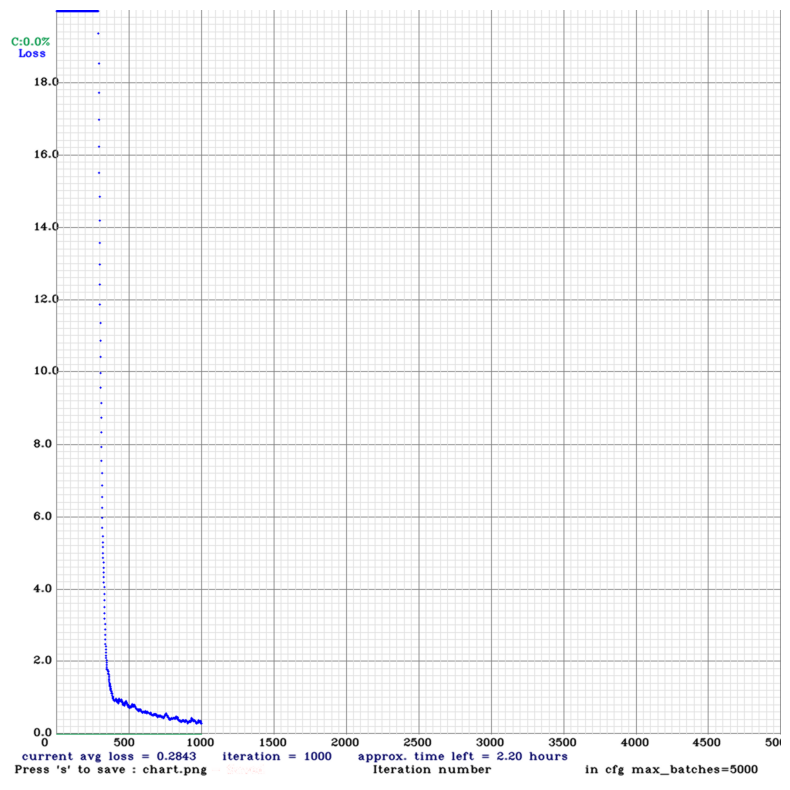

In [ ]:
imShow('chart.png')

Colab이 어떤 이유에서 더 이상 학습을 진행하지 않는다고 해도 100 iteration마다 **yolov3_custom_last.weights** 이라는 weight파일이 **mydrive/yolov3/backup/** 폴더에 저장이 된다.
다음 명령문을 통해 마지막으로 저장한 weights파일을 다시 불러읽을 수 있다.
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show

/bin/bash: line 1: ./darknet: Is a directory


# Step 6: 커스텀 Object Detector 실행하기

커스텀 Object Detector가 만들어졌기 때문에 이제 실행을 하면 됨.

In [ ]:
# custom cfg 를 test mode 로 바꾸기
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


 CUDA-version: 12020 (12020), cuDNN: 8.9.6, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 890, cudnn_half = 0, GPU: NVIDIA L4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     64       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  64 3.775 BF
   2 conv     32       1 x 1/ 1    320 x 320 x  64 ->  320 x 320 x  32 0.419 BF
   3 conv     64       3 x 3/ 1    320 x 320 x  32 ->  320 x 320 x  64 3.775 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  64 0.007 BF
   5 conv    128       3 x 3/ 2    320 x 320 x  64 ->  160 x 160 x 128 3.775 BF
   6 conv     64       1 x 1/ 1    160 x 160 x 128 ->  160 x 160 x  64 0.419 BF
   7 conv    128       3 x 3/ 1    160 x 160 x  64 ->  160 x 160 x 128 3.775 BF
   8 Shortcut Layer: 5,

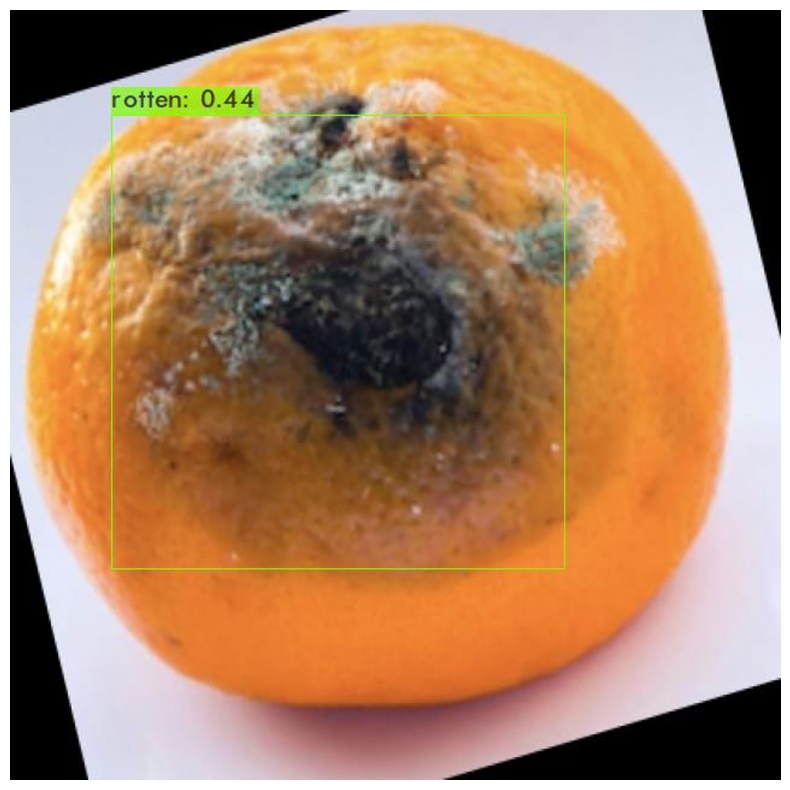

In [ ]:
# 구글 드라이브로 원하는 영상을 업로드한 후에 커스텀 detector를 돌리기. 여기서 -thresh 0.3은 Accuracy가 0.3이하가 되는 Object의 Bounding Box는 보이지 않게 하겠다는 뜻임
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights ../gdrive/MyDrive/image/'1.jpg' -thresh 0.3
imShow('predictions.jpg')

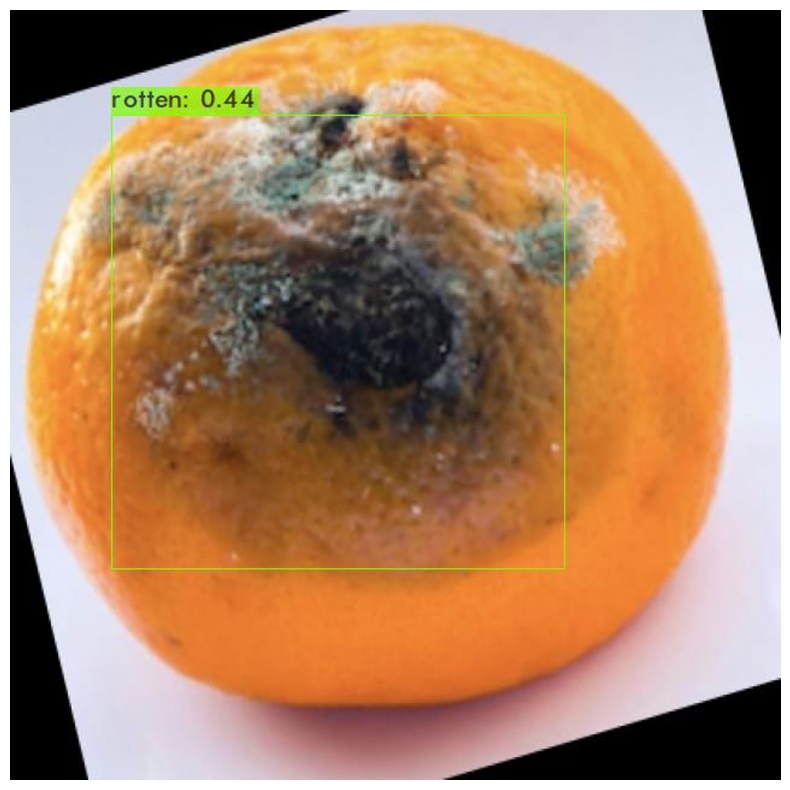

In [ ]:
imShow('predictions.jpg')

이 코드를 만든 AI Guy의 유튜브 링크:

[The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q)